In [1]:
import pickle
import os

FOLDER = os.getcwd() + "/15cells"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    psf = pickle.load(file)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import numpy as np
from utils import *

ModuleNotFoundError: No module named 'torch'

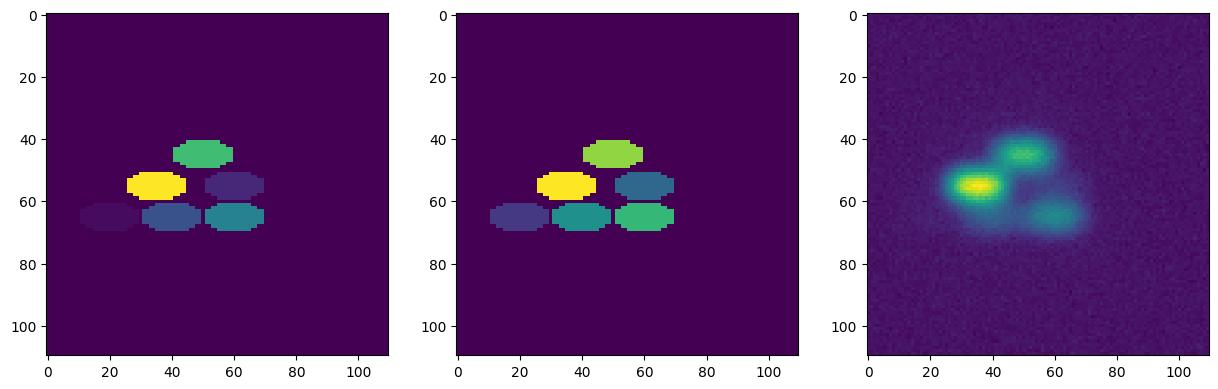

In [ ]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

In [ ]:
randomPts = 0
originalOutput = out
sourcePts = GetSourcePts(mask)
recoveredImage = InverseMatrix(out, mask, sourcePts, learningRate = 1, psf=psf)

[0.8333333333333334, 1.0, 0.3333333333333333, 0.16666666666666666, 0.5, 0.6666666666666666]
[[0.71781082]
 [1.        ]
 [0.16673161]
 [0.0926772 ]
 [0.30053295]
 [0.47658022]]


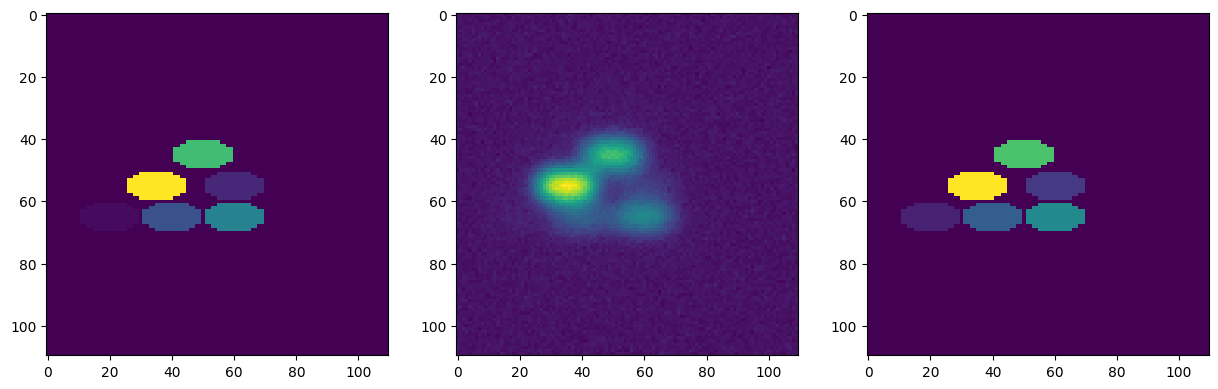

In [ ]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(out)
axarr[2].imshow(recoveredImage)
plt.show()

array([[1.        , 0.99996837],
       [0.99996837, 1.        ]])

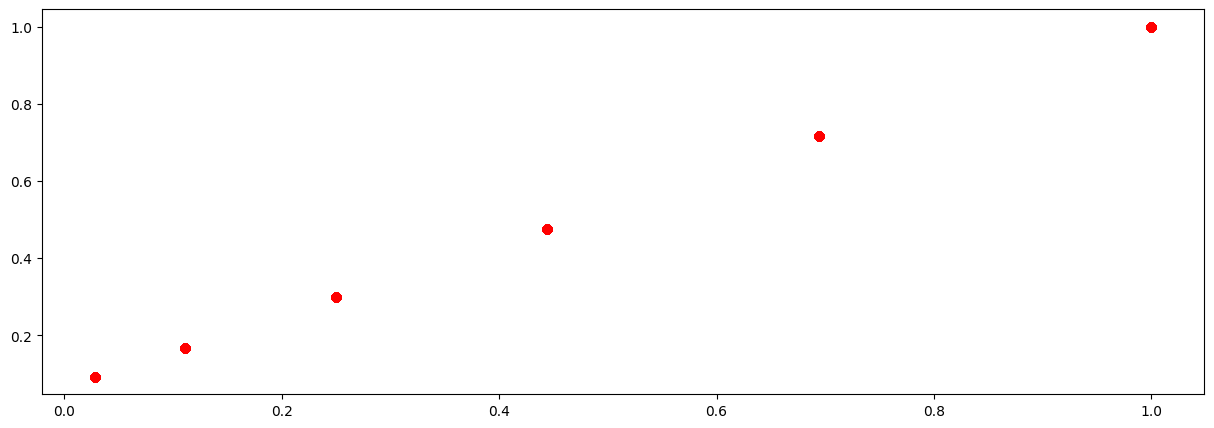

In [ ]:
original_intensity = []
custom_intensity = []


for x in sourcePts:
    original_intensity.append(ori[x[0],x[1]])
    custom_intensity.append(recoveredImage[x[0],x[1]])

original_intensity = np.array(original_intensity)
original_intensity = original_intensity/max(original_intensity)
custom_intensity = np.array(custom_intensity)
custom_intensity = custom_intensity/max(custom_intensity)

plt.plot(original_intensity,custom_intensity,'ro')

#Calculate correlation coefficient
np.corrcoef(original_intensity,custom_intensity)

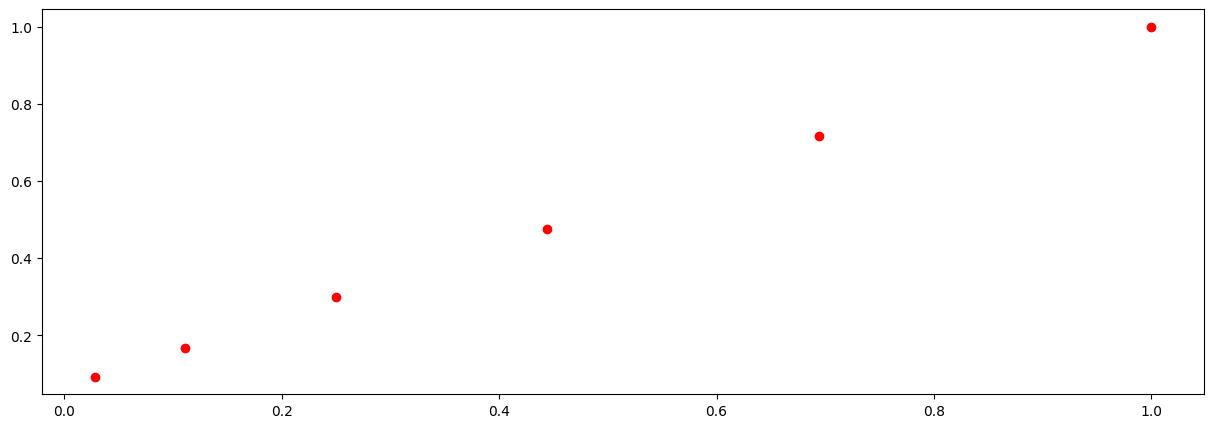

array([[1.        , 0.99996837],
       [0.99996837, 1.        ]])

In [ ]:
#Get average intensity in each mask

average_original_intensity = {}
for x in sourcePts:
    if not mask[x[0],x[1]] in average_original_intensity:
        average_original_intensity[mask[x[0],x[1]]] = [ori[x[0],x[1]],1]
    else:
        average_original_intensity[mask[x[0],x[1]]][0] += ori[x[0],x[1]]
        average_original_intensity[mask[x[0],x[1]]][1] += 1

average_custom_intensity = {}
for x in sourcePts:
    if not mask[x[0],x[1]] in average_custom_intensity:
        average_custom_intensity[mask[x[0],x[1]]] = [recoveredImage[x[0],x[1]],1]
    else:
        average_custom_intensity[mask[x[0],x[1]]][0] += recoveredImage[x[0],x[1]]
        average_custom_intensity[mask[x[0],x[1]]][1] += 1


average_original_intensity = [ v[0]/v[1] for k, v in average_original_intensity.items() ]
average_original_intensity = np.array(average_original_intensity)
average_inteaverage_original_intensitynsity = average_original_intensity/max(average_original_intensity)

average_custom_intensity = [ v[0]/v[1] for k, v in average_custom_intensity.items() ]
average_custom_intensity = np.array(average_custom_intensity)
average_custom_intensity = average_custom_intensity/max(average_custom_intensity)

plt.plot(average_original_intensity,average_custom_intensity,'ro')
plt.show()

#Calculate correlation coefficient
np.corrcoef(average_original_intensity,average_custom_intensity)